# imports

In [1]:
import cv2                                      # for image operations
import matplotlib.pyplot as plt                 # for visualisation
import numpy as np                              # for numerical operations
from google.colab.patches import cv2_imshow     # for displaying images on colab
from tqdm import tqdm
import random

# helper

In [2]:
def plot_side_by_side(img_1, img_2, title1="Original Image", title2="Processed Image"):
    """
    A function to plot two images side by side.
    """
    if len(img_1.shape) == 3 or len(img_2.shape) == 3:
        img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
        img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(img_1, cmap='gray')
    axs[1].imshow(img_2, cmap='gray')

    axs[0].set_title(title1)
    axs[1].set_title(title2)

# get the images

In [3]:
import gdown

images = {
    "https://drive.google.com/file/d/1bQP-mNdFWTIOOI959cqaUj8dNZhz8INY/view?usp=drive_link": "two-dots.png",
    "https://drive.google.com/file/d/170tWS0KLfk-GTqLvp5jwqIksdzMDLxK_/view?usp=drive_link": "one-dot.png",
    "https://drive.google.com/file/d/1dROjgxGsPRytsVrXRlRQP3ecKH2BjSC5/view?usp=drive_link": "single-line.png",
    "https://drive.google.com/file/d/1iVW5e3jRa23v1DBK0pQET3vFOtSaNj3a/view?usp=drive_link": "building.png",
    "https://drive.google.com/file/d/1hAu5mSO98lq11PlYypxbHacTxmRn5De6/view?usp=drive_link": "coins.jpg",
    "https://drive.google.com/file/d/1QLuG3P3D8ZFXd8tHB1vMNKvNm-9jHxU0/view?usp=sharing": "basic_circle.jpg"
}

for url, file_name in images.items():

    gdown.download(url, file_name, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1bQP-mNdFWTIOOI959cqaUj8dNZhz8INY
To: /content/two-dots.png
100%|██████████| 5.37k/5.37k [00:00<00:00, 11.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=170tWS0KLfk-GTqLvp5jwqIksdzMDLxK_
To: /content/one-dot.png
100%|██████████| 181/181 [00:00<00:00, 462kB/s]
Downloading...
From: https://drive.google.com/uc?id=1dROjgxGsPRytsVrXRlRQP3ecKH2BjSC5
To: /content/single-line.png
100%|██████████| 3.02k/3.02k [00:00<00:00, 7.63MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iVW5e3jRa23v1DBK0pQET3vFOtSaNj3a
To: /content/building.png
100%|██████████| 481k/481k [00:00<00:00, 47.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hAu5mSO98lq11PlYypxbHacTxmRn5De6
To: /content/coins.jpg
100%|██████████| 38.8k/38.8k [00:00<00:00, 39.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QLuG3P3D8ZFXd8tHB1vMNKvNm-9jHxU0
To: /content/basic_circle.jpg
100%|██████████| 47.2k/47.2k [00:00<00:00, 47.1MB/s]


# Hough Transform

## Hough Lines

***y = mx + b***

> A problem with using m, c space to represent lines is that they are limited and cannot represent vertical lines. To solve this, we use polar coordinates to represent lines.

***x.cosθ + y.sinθ = ρ***

### ***Exercise 1.1*** - Implement Hough Transform from scratch.

```
1.Initialize accumulator H to all zeros

2.For each edge point (x,y) in the image

    For θ = 0 to 180
        ρ = x cos θ + y sin θ
        H(θ, ρ) = H(θ, ρ) + 1
    end
end

3.Find the value(s) of (θ, ρ) where H(θ, ρ) is a local maximum

4.The detected line in the image is given by ρ = x cos θ + y sin θ
```



In [4]:
def houghLine(image):
    '''
    Basic Hough line transform that builds the accumulator array.

    Input : image : edge image (canny)
    Output : accumulator : the accumulator of hough space
             thetas : values of theta (-90 : 90)
             rs : values of radius (-max distance : max distance)
    '''

    height, width = image.shape

    # max possible rho values - max distance is diagonal one
    Maxdist = int(np.round(np.sqrt(width**2 + height ** 2))) # maximum distance from the origin (0,0) to any point in the input image

    ### initialize parameter space rs, thetas ###

    thetas = np.deg2rad(np.arange(0, 180)) # theta in range from -90 to 90 degrees
    # rs = np.linspace(-Maxdist, Maxdist, 2*Maxdist) # a range of possible distances from the origin to the line

    ### Create accumulator array and initialize to zero ###
    accumulator = np.zeros((2 * Maxdist, len(thetas)))
    # 2 * max_rho is used to ensure that the accumulator array has enough space to cover both positive and negative values of ρ

    for y in range(height): # iterate over each pixel in the edge-detected image
        for x in range(width):
            if image[y, x] > 0: # each edge pixel found
                for k in range(len(thetas)): # for each theta
                    rho = x*np.cos(thetas[k]) + y * np.sin(thetas[k]) # calculate rho

                    accumulator[int(rho) + Maxdist, k] += 1 # increment accumulator at r, theta
                    # int(rho) + Maxdist is used to map the continuous ρ values to discrete indices in the accumulator array

    return accumulator, thetas #, rs

### ***Exercise 1.2*** - Let's dive into parameter space of Hough.

P.S. Do not forget to read the images GRAYSCALE.

#### Points

Use the given function to generate images with dots in it. Examine the change on hough space depending on the number of circles.


> Every point is mapped to a curve in Hough Space. All the curves intersected at a point in Hough domain.



In [38]:
def generate_image_with_circles(num_circles, width=300, height=300):
    image = np.zeros((height, width), dtype=np.uint8)

    # Generate random circles
    for _ in range(num_circles):

        radius = 10

        # Randomly generate circle parameters
        x = random.randint(radius, width - radius)
        y = random.randint(radius, height - radius)

        # Draw white circle
        cv2.circle(image, (x, y), radius, 255, -1)

    return image

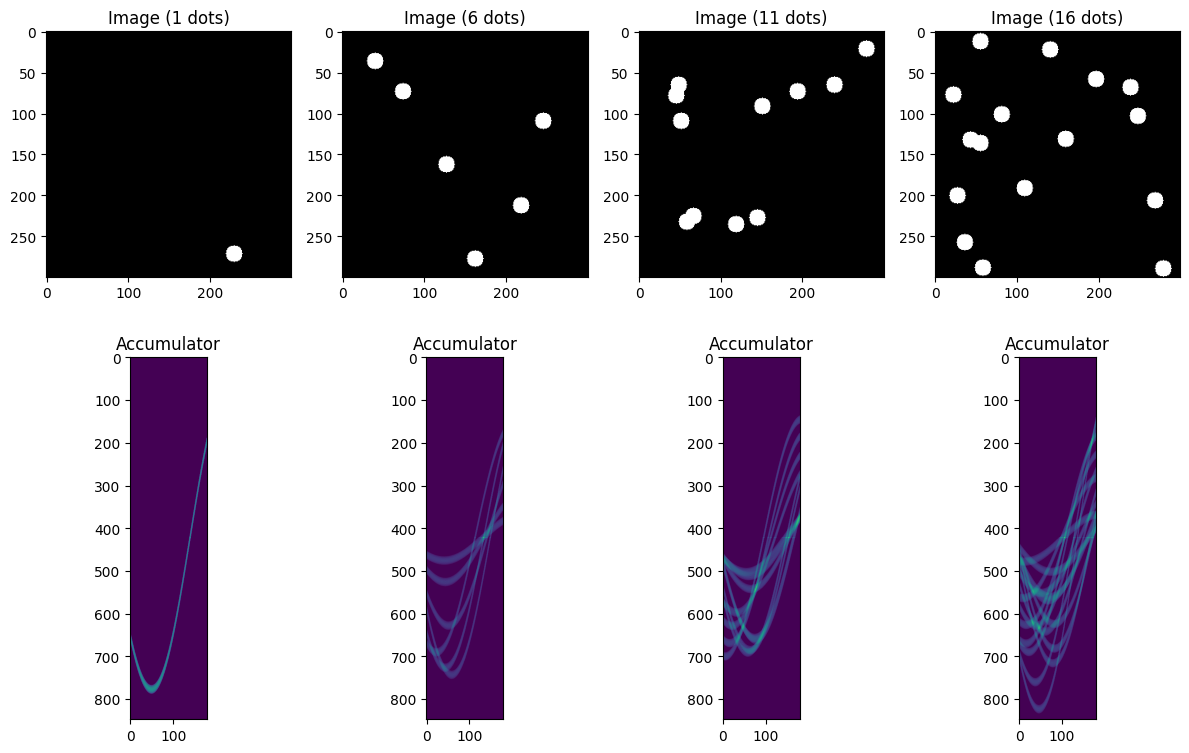

In [39]:
num_dots = np.arange(1, 21, 5)
fig, axes = plt.subplots(2, len(num_dots), figsize=(12, 8))


for i, num_dot in enumerate(num_dots):
    image = generate_image_with_circles(num_dot)

    accumulator, _ = houghLine(image)

    axes[0, i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f'Image ({num_dot} dots)')

    axes[1, i].imshow(accumulator)
    axes[1, i].set_title('Accumulator')

plt.tight_layout()
plt.show()

Every point was mapped to a curve.

#### Lines

All curves in Hough domain have only one intersection point for each line in the image domain.

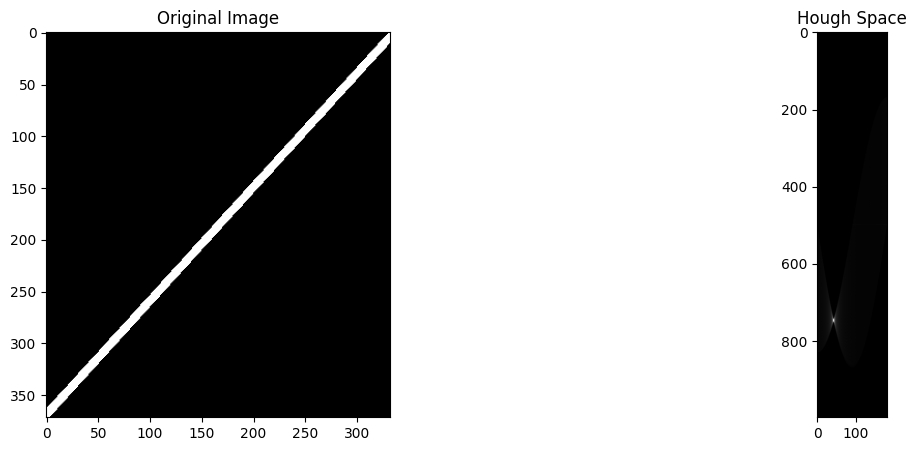

In [25]:
line = cv2.imread("single-line.png", 0)

accumulator_line, thetas_line = houghLine(line)
plot_side_by_side(line, accumulator_line, "Original Image", "Hough Space")

### ***Exercise 1.3*** - Line Detection with Hough (OpenCV implementation)

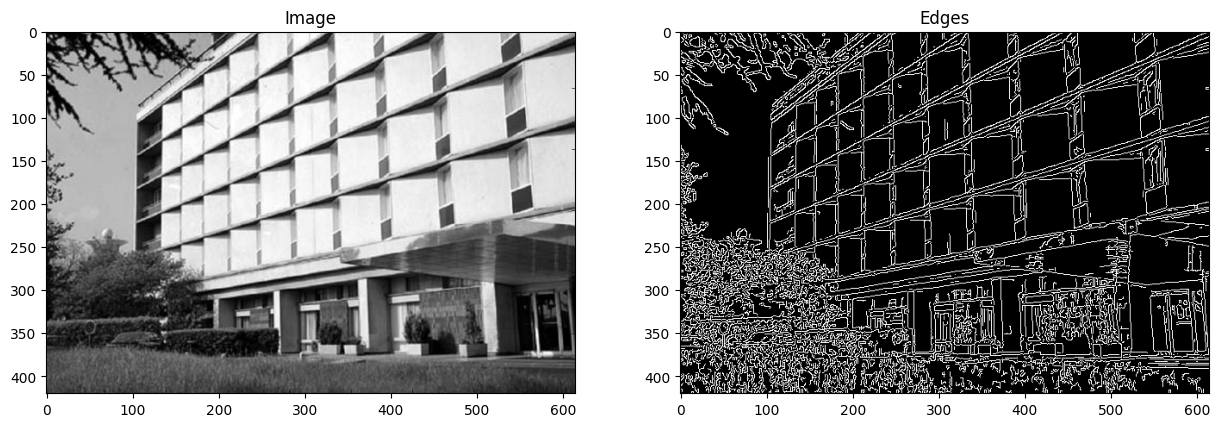

In [49]:
# Load image
image = cv2.imread('building.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

low_threshold = 50
high_threshold = 100
edges = cv2.Canny(gray, low_threshold, high_threshold)

plot_side_by_side(gray, edges, "Image", "Edges")

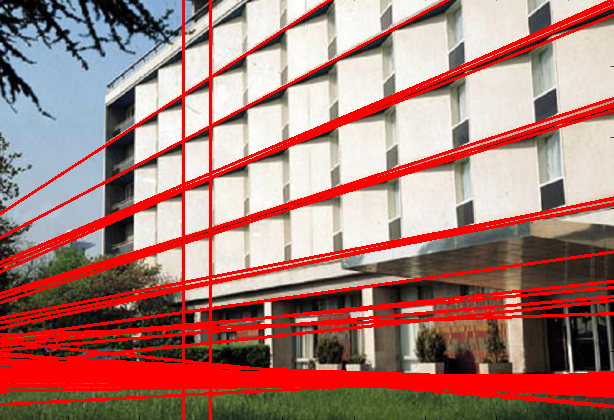

In [50]:
# Define the Hough transform parameters
rho = 1
theta = np.pi / 180
threshold = 200

# Run Hough on the edge-detected image
lines = cv2.HoughLines(edges, rho, theta, threshold)

# Make a blank the same size as our image to draw on
line_image = np.copy(image)

# Iterate over the output "lines" and draw lines on the image copy
if lines is not None:
    for rho, theta in lines[:, 0]:
        # In polar coordinates, a line is represented by two parameters: ρ (rho) and θ (theta).
        # Given ρ and θ, we can convert them to Cartesian coordinates using the following equations:
        # x = ρ * cos(θ)
        # y = ρ * sin(θ)

        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        # x0 and y0 represent the Cartesian coordinates of a point on the detected line in the image space

        # We extend the line segment in both directions from the point (x, y) by a certain length.
        # we need to move perpendicular to the line
        # This length is chosen to be sufficiently long to cover the entire image. Here, it's chosen as 1000 pixels.
        x1 = int(x0 + 1000 * (b))
        y1 = int(y0 - 1000 * (a))
        x2 = int(x0 - 1000 * (b))
        y2 = int(y0 + 1000 * (a))
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

cv2_imshow(line_image)

## Hough Circles

The same idea is applied for other shapes. Onces you have parametric equation that describes the shape you can build parameter space and detect that shape. For the circle

$r2=(x−x0)2+(y−y0)2$

Circle parameters are center (x0, y0) and radius r
Your parameter space now is 3D parameter space.

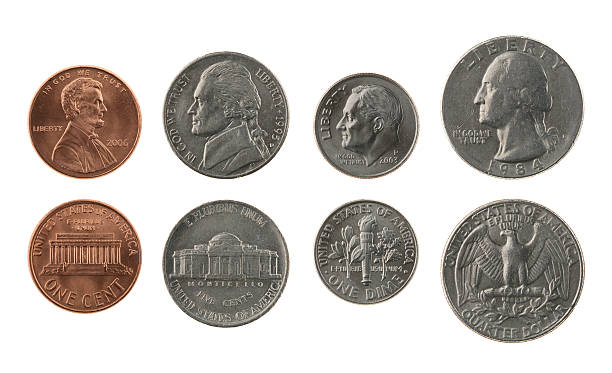

In [16]:
coins = cv2.imread("coins.jpg")
cv2_imshow(coins)

### ***Exercise 2.1*** - Try to find the coins in the image with Hough Circles. Try different parameters and observe their effects.

```
cv2.HoughCircles(image, dp, minDist, Param1, Param2, minRadius, maxRadius)
```

* `dp`: Ratio of the resolution of original image to the accumulator matrix.
* `minDist`: Minimum distance between detected circles.
* `Param1`: Canny edge detection requires two parameters — minVal and maxVal. Param1 is the higher threshold of the two. The second one is set as Param1/2.
* `Param2`: Accumulator threshold for the candidate detected circles. By increasing this threshold value, we can ensure that only the best circles, corresponding to larger accumulator values, are returned.
* `minRadius`: Minimum circle radius.
* `maxRadius`: Maximum circle radius.

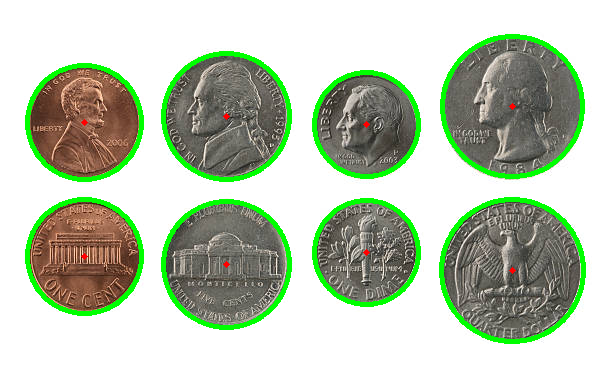

In [17]:
coins_copy = coins.copy()

coins_gray = cv2.cvtColor(coins, cv2.COLOR_BGR2GRAY)

gray_blurred = cv2.GaussianBlur(coins_gray, (9, 9), 2) # Apply GaussianBlur to reduce noise and improve circle detection

circles = cv2.HoughCircles(
    gray_blurred,
    cv2.HOUGH_GRADIENT, # a variation of the Hough Transform technique based on gradients
    1,                  # the scale of the accumulator relative to the input image
    20,                 # minimum distance between the centers of the detected circles
    param1 = 50,        # a threshold parameter for the Canny edge detector
    param2 = 30,        # accumulator threshold for the circle centers
    minRadius = 50,     # the minimum radius of the circles to be detected
    maxRadius = 90      # the maximum radius of the circles to be detected
    )

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(coins_copy, (x, y), r, (0, 255, 0), 4) # draw the circle
        cv2.circle(coins_copy, (x, y), 1, (0, 0, 255), 4) # draw the center of the circle
    cv2_imshow(coins_copy)
else:
    print("No circles detected.")

### Exercise 2.2 - Implement Hough Circle from scratch

In [18]:
def hough_circle_detection(image, min_radius, max_radius, threshold):

    height, width = image.shape

    # Step 1: Edge detection
    edges = cv2.Canny(image, 50, 150)

    # Step 2: Initialize accumulator array
    accumulator = np.zeros((image.shape[0], image.shape[1], max_radius - min_radius + 1), dtype=np.uint8)

    # Step 3: Voting
    edge_points = np.column_stack(np.nonzero(edges))
    # nonzero -> returns the indices of the elements that are non-zero in the edges array
    # column_stack --> takes a sequence of 1-D arrays and stacks them as columns to make a single 2-D array.
    #                  Here, np.nonzero(edges) returns a tuple of arrays representing row and column indices of non-zero elements.

    for x, y in tqdm(edge_points):

        for r in range(min_radius, max_radius + 1):

            for theta in range(0, 360): # we consider every possible orientation of the radius vector

                # calculate the coordinates of candidate circle centers around each edge point
                center_x = int(x - r * np.cos(np.radians(theta))) # a = x - r.cos(theta)
                center_y = int(y - r * np.sin(np.radians(theta))) # b = y - r.cos(theta)

                if 0 <= center_x < width and 0 <= center_y < height:
                    accumulator[center_y, center_x, r - min_radius] += 1

    # Step 4: Find circles with votes above threshold
    circles = []
    for r in range(min_radius, max_radius + 1):
        for y in range(height):
            for x in range(width):
                if accumulator[y, x, r - min_radius] > threshold:
                    circles.append((x, y, r))

    return circles

100%|██████████| 1103/1103 [04:28<00:00,  4.11it/s]


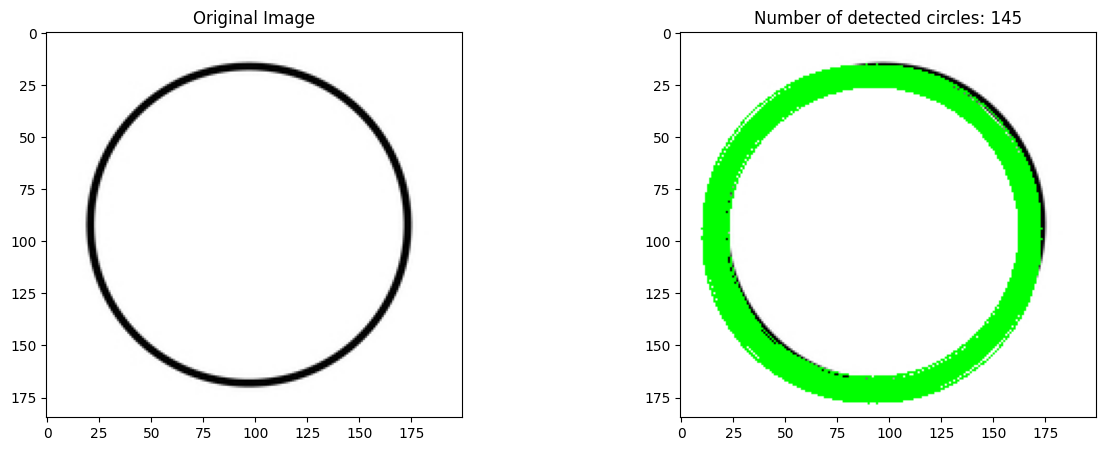

In [19]:
image = cv2.imread('basic_circle.jpg', cv2.IMREAD_GRAYSCALE)

min_radius = 20
max_radius = 100
threshold = 100

detected_circles = hough_circle_detection(image, min_radius, max_radius, threshold)

# Draw detected circles
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

for x, y, r in detected_circles:
    cv2.circle(output_image, (x, y), r, (0, 255, 0), 1)

plot_side_by_side(image, output_image, "Original Image", f"Number of detected circles: {len(detected_circles)}")